# TabPFN Hands-On-Demo

**Welcome to this enhanced and educational walkthrough of TabPFN!**

TabPFN is a novel machine learning model that is exceptionally fast and requires no hyperparameter tuning. It is particularly powerful for tabular data, which is a common data format in many real-world applications. This notebook will not only demonstrate how to use TabPFN but also provide clear explanations of the underlying concepts.

**What you will learn:**

* What TabPFN is and why it's a game-changer for tabular data.
* How to set up and run TabPFN on your local machine or using the client API.
* How to use TabPFN for both classification and regression tasks.
* A comparison of TabPFN's performance against other popular models like XGBoost and RandomForest.
* Advanced features of TabPFN, including handling text data, unsupervised learning, and model interpretability.

Let's get started!



## Table of Contents

1.  [Installation](#installation)
2.  [Backend Selection](#backend-selection)
3.  [**Classification with TabPFN**](#classification)
4.  [**Regression with TabPFN**](#regression)
5.  [Handling Text Data](#text-data)
6.  [Unsupervised Learning with TabPFN](#unsupervised-learning)
   - Data Imputation
   - Anomaly Detection
   - Clustering Applications
7.  [Model Interpretability](#interpretability)
   - Feature Importance Analysis
   - Explaining Predictions with SHAP
   - Extracting and Visualizing Embeddings
8.  [Predictive Behavior](#behavior)
9.  [**Time Series Prediction**](#timeseries)



# Installation [Running this cell required!] <a name="installation"></a>

First, we need to install the necessary libraries. This includes TabPFN itself, as well as other libraries for data manipulation and baseline model comparisons. If you are asked to restart the runtime after installation, please do so.


In [1]:
## Base library Installation
# Install Baselines for model comparison
!uv pip install catboost xgboost

# Install the datasets library for loading example data
!uv pip install datasets

# Install rich for better and more readable printing
!uv pip install rich


## TabPFN Installation optimized for Google Colab
# Install the TabPFN Client library
!uv pip install tabpfn-client

# Install tabpfn from source
# Clone the repository: shallow for speedup
!git clone --depth 1 https://github.com/PriorLabs/tabpfn

# Speeding up installation in this notebook:
# Remove torch dependency as it is already installed on colab (do not run this in your local setup)
!sed -i "/torch/d" tabpfn/pyproject.toml

# Step 3: Install using the correct directory name 'tabpfn'
!uv pip install -e "tabpfn"

# Install TabPFN extensions for additional functionalities
!git clone https://github.com/PriorLabs/tabpfn-extensions

# Speeding up installation in this notebook:
# Remove torch dependency as it is already installed on colab (do not run this in your local setup)
!sed -i "/torch/d" tabpfn-extensions/pyproject.toml

!uv pip install -e tabpfn-extensions[all]

Using Python 3.12.11 environment at: /usr
Audited 2 packages in 103ms
Using Python 3.12.11 environment at: /usr
Audited 1 package in 102ms
Using Python 3.12.11 environment at: /usr
Audited 1 package in 86ms
Using Python 3.12.11 environment at: /usr
Audited 1 package in 91ms
fatal: destination path 'tabpfn' already exists and is not an empty directory.
Using Python 3.12.11 environment at: /usr
Resolved 32 packages in 51ms
Prepared 1 package in 1.53s
Uninstalled 1 package in 1ms
Installed 1 package in 3ms
 ~ tabpfn==2.1.3 (from file:///content/tabpfn)
fatal: destination path 'tabpfn-extensions' already exists and is not an empty directory.
Using Python 3.12.11 environment at: /usr
Resolved 65 packages in 98ms
Prepared 1 package in 2.41s
Uninstalled 1 package in 0.54ms
Installed 1 package in 1ms
 ~ tabpfn-extensions==0.1.4 (from file:///content/tabpfn-extensions)


***Note: remember to restart the runtime after the installation.***

# Necessary Imports for the Notebook [Running this cell required!]

Now that the libraries are installed, let's import all the necessary modules for this notebook.




In [2]:
# Standard Library Imports

# TabPFN and Extensions

try:
    from tabpfn_extensions.post_hoc_ensembles.sklearn_interface import (
        AutoTabPFNClassifier,
    )

    from tabpfn import TabPFNClassifier, TabPFNRegressor
except ImportError:
    raise ImportError(
        "Warning: Could not import TabPFN / TabPFN extensions. Please run installation above and restart the session afterwards (Runtime > Restart Session)."
    )

# Data Science & Visualization
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch

# Other ML Models
from catboost import CatBoostClassifier, CatBoostRegressor

# Notebook UI/Display
from IPython.display import Markdown, display
from rich.console import Console
from rich.panel import Panel
from rich.prompt import Prompt
from rich.rule import Rule
from sklearn.compose import make_column_selector, make_column_transformer

# Scikit-Learn: Data & Preprocessing
from sklearn.datasets import fetch_openml, load_breast_cancer

# Scikit-Learn: Models
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import mean_squared_error, roc_auc_score
from sklearn.model_selection import (
    KFold,
    StratifiedKFold,
    cross_val_score,
    train_test_split,
)
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from xgboost import XGBClassifier, XGBRegressor

# This transformer will be used to handle categorical features for the baseline models
column_transformer = make_column_transformer(
    (
        OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1),
        make_column_selector(dtype_include=["object", "category"]),
    ),
    remainder="passthrough",
)

# Backend Selection [Running this cell required!] <a name="backend-selection"></a>


TabPFN can be run in two ways: locally on your machine (if you have a GPU) or by using the TabPFN client, which sends the data to a server for computation.
In your project you would either use the local version (which requires a GPU) with :
```python
# Simple import for TabPFN
from tabpfn import TabPFNClassifier

# Now you can use it like any other sklearn classifier
# model = TabPFNClassifier()
print("TabPFNClassifier imported successfully.")
```

or the **client** API (which uses a remote server):

```python
# Simple import for TabPFN
from tabpfn_client import TabPFNClassifier

# Now you can use it like any other sklearn classifier
# model = TabPFNClassifier()
print("TabPFNClassifier imported successfully.")
```


For demonstration purposes, the cell below provides an interactive way to switch between those:


In [3]:
console = Console()

console.print(Panel.fit("[bold magenta]TabPFN Demo: Backend Selection[/bold magenta]"))
console.print("\nThis script can run TabPFN using one of two backends:")
console.print("  [bold]1. local:[/bold] Uses a local GPU (NVIDIA). Requires CUDA.")
console.print(
    "  [bold]2. client:[/bold] Uses the TabPFN API. Requires an internet connection and a free account."
)

backend = Prompt.ask(
    "\n[bold]Choose your backend[/bold] - If not field to enter is shown restart the cell.",
    choices=["client", "local"],
    default="client",
)

console.print(
    f"\n✅ You have selected the '[bold green]{backend}[/bold green]' backend."
)

console.print(Rule(f"[bold]Setting up [cyan]{backend}[/cyan] backend[/bold]"))

if backend == "local":
    console.print("Attempting local backend setup...")
    import torch

    if not torch.cuda.is_available():
        console.print(
            "[bold red]Error:[/bold red] GPU device not found. For fast training, please enable GPU.",
            style="red",
        )
        console.print(
            "In Colab: Go to [bold]Runtime -> Change runtime type -> Hardware accelerator -> GPU.[/bold]",
            style="yellow",
        )
        raise SystemError("GPU device not found.")
    console.print(
        "[bold green]✅ GPU is available.[/bold green] Importing local TabPFN library..."
    )
    from tabpfn import TabPFNClassifier, TabPFNRegressor

    console.print("[bold green]✅ TabPFN (local) imported successfully.[/bold green]")
elif backend == "client":
    console.print("Attempting client backend setup...")
    console.print("Importing TabPFN client library...")
    from tabpfn_client import TabPFNClassifier, TabPFNRegressor, init

    init()
    console.print("[bold green]✅ TabPFN (client) initialized.[/bold green]")

╭────────────────────────────────╮
│ TabPFN Demo: Backend Selection │
╰────────────────────────────────╯

This script can run TabPFN using one of two backends:

1. local: Uses a local GPU (NVIDIA). Requires CUDA.

2. client: Uses the TabPFN API. Requires an internet connection and a free account.

Choose your backend - If not field to enter is shown restart the cell. [client/local] (client):

local


✅ You have selected the 'local' backend.

──────────────────────────────────────────── Setting up local backend ─────────────────────────────────────────────

Attempting local backend setup...

✅ GPU is available. Importing local TabPFN library...

✅ TabPFN (local) imported successfully.

# Classification with TabPFN <a name="classification"></a>

Now, let's dive into a practical example of using TabPFN for a classification task. We will use the well-known Parkinson's Disease dataset. The goal is to predict the presence of Parkinson's disease based on various voice measurements.

We will compare TabPFN's performance against other popular machine learning models: RandomForest, XGBoost, and CatBoost. The performance metric we will use is the [ROC AUC](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html) score.


In [4]:
# Parkinson's Disease dataset: Predict Parkinson's disease presence
# Features: Voice measurements (e.g., frequency, amplitude)
# Samples: 195 cases
df = fetch_openml("parkinsons")

X, y = df.data, df.target

# Print dataset description
display(Markdown(df["DESCR"]))

display(X)

**Author**:   
**Source**: UCI
**Please cite**: 'Exploiting Nonlinear Recurrence and Fractal Scaling Properties for Voice Disorder Detection', Little MA, McSharry PE, Roberts SJ, Costello DAE, Moroz IM. BioMedical Engineering OnLine 2007, 6:23 (26 June 2007) 

* Abstract: 

Oxford Parkinson's Disease Detection Dataset

* Source:

The dataset was created by Max Little of the University of Oxford, in collaboration with the National Centre for Voice and Speech, Denver, Colorado, who recorded the speech signals. The original study published the feature extraction methods for general voice disorders.

* Data Set Information:
This dataset is composed of a range of biomedical voice measurements from 31 people, 23 with Parkinson's disease (PD). Each column in the table is a particular voice measure, and each row corresponds one of 195 voice recording from these individuals ("name" column). The main aim of the data is to discriminate healthy people from those with PD, according to "status" column which is set to 0 for healthy and 1 for PD. 

Further details are contained in the following reference -- if you use this dataset, please cite: 
Max A. Little, Patrick E. McSharry, Eric J. Hunter, Lorraine O. Ramig (2008), 'Suitability of dysphonia measurements for telemonitoring of Parkinson's disease', IEEE Transactions on Biomedical Engineering (to appear).


* Attribute Information:

Matrix column entries (attributes): 
name - ASCII subject name and recording number 
MDVP:Fo(Hz) - Average vocal fundamental frequency 
MDVP:Fhi(Hz) - Maximum vocal fundamental frequency 
MDVP:Flo(Hz) - Minimum vocal fundamental frequency 
MDVP:Jitter(%),MDVP:Jitter(Abs),MDVP:RAP,MDVP:PPQ,Jitter:DDP - Several measures of variation in fundamental frequency 
MDVP:Shimmer,MDVP:Shimmer(dB),Shimmer:APQ3,Shimmer:APQ5,MDVP:APQ,Shimmer:DDA - Several measures of variation in amplitude 
NHR,HNR - Two measures of ratio of noise to tonal components in the voice 
status - Health status of the subject (one) - Parkinson's, (zero) - healthy 
RPDE,D2 - Two nonlinear dynamical complexity measures 
DFA - Signal fractal scaling exponent 
spread1,spread2,PPE - Three nonlinear measures of fundamental frequency variation

Downloaded from openml.org.

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22
0,119.992,157.302,74.997,0.00784,0.00007,0.00370,0.00554,0.01109,0.04374,0.426,...,0.02971,0.06545,0.02211,21.033,0.414783,0.815285,-4.813031,0.266482,2.301442,0.284654
1,122.400,148.650,113.819,0.00968,0.00008,0.00465,0.00696,0.01394,0.06134,0.626,...,0.04368,0.09403,0.01929,19.085,0.458359,0.819521,-4.075192,0.335590,2.486855,0.368674
2,116.682,131.111,111.555,0.01050,0.00009,0.00544,0.00781,0.01633,0.05233,0.482,...,0.03590,0.08270,0.01309,20.651,0.429895,0.825288,-4.443179,0.311173,2.342259,0.332634
3,116.676,137.871,111.366,0.00997,0.00009,0.00502,0.00698,0.01505,0.05492,0.517,...,0.03772,0.08771,0.01353,20.644,0.434969,0.819235,-4.117501,0.334147,2.405554,0.368975
4,116.014,141.781,110.655,0.01284,0.00011,0.00655,0.00908,0.01966,0.06425,0.584,...,0.04465,0.10470,0.01767,19.649,0.417356,0.823484,-3.747787,0.234513,2.332180,0.410335
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
190,174.188,230.978,94.261,0.00459,0.00003,0.00263,0.00259,0.00790,0.04087,0.405,...,0.02745,0.07008,0.02764,19.517,0.448439,0.657899,-6.538586,0.121952,2.657476,0.133050
191,209.516,253.017,89.488,0.00564,0.00003,0.00331,0.00292,0.00994,0.02751,0.263,...,0.01879,0.04812,0.01810,19.147,0.431674,0.683244,-6.195325,0.129303,2.784312,0.168895
192,174.688,240.005,74.287,0.01360,0.00008,0.00624,0.00564,0.01873,0.02308,0.256,...,0.01667,0.03804,0.10715,17.883,0.407567,0.655683,-6.787197,0.158453,2.679772,0.131728
193,198.764,396.961,74.904,0.00740,0.00004,0.00370,0.00390,0.01109,0.02296,0.241,...,0.01588,0.03794,0.07223,19.020,0.451221,0.643956,-6.744577,0.207454,2.138608,0.123306


In [5]:
# Alternative datasets (commented for reference):

# German Credit Fraud (ID: 31)
# Samples: 1,000
# Features: 20 (account info, credit history, employment)
# Target: Good/Bad credit risk
# df = fetch_openml(data_id=31)

# Cholesterol dataset: Predict cholesterol levels
# Features: Patient characteristics, medical measurements
# Samples: 303 patients
# Target: Cholesterol levels in mg/dl
# df = fetch_openml('cholesterol', version=2, as_frame=True)

# Heart Disease dataset (Statlog): Predict presence of heart disease
# Features: Clinical and test measurements
# Samples: 270 patients
# Target: Binary heart disease diagnosis
# df = fetch_openml("heart-statlog", version=1)

# Diabetes dataset: Predict diabetes presence
# Features: Medical measurements, patient history
# Samples: 768 patients
# Target: Binary diabetes diagnosis
# df = fetch_openml("diabetes", version=1)

In [6]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42
)

# Train and evaluate the TabPFN classifier
tabpfn_classifier = TabPFNClassifier(random_state=42)
tabpfn_classifier.fit(X_train, y_train)
y_pred_proba = tabpfn_classifier.predict_proba(X_test)

# Calculate the ROC AUC score
roc_auc = roc_auc_score(y_test, y_pred_proba[:, 1])
print(f"TabPFN ROC AUC Score: {roc_auc:.4f}")

tabpfn-v2-classifier-finetuned-zk73skhh.(…):   0%|          | 0.00/29.0M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/37.0 [00:00<?, ?B/s]

TabPFN ROC AUC Score: 0.9598


### Comparing TabPFN with Other Classifiers

To get a better sense of TabPFN's performance, let's compare it with other popular classification models using cross-validation. This will give us a more robust estimate of each model's performance.


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    8.6s finished


Text(0.5, 1.0, 'Model Comparison - 3-fold Cross-validation')

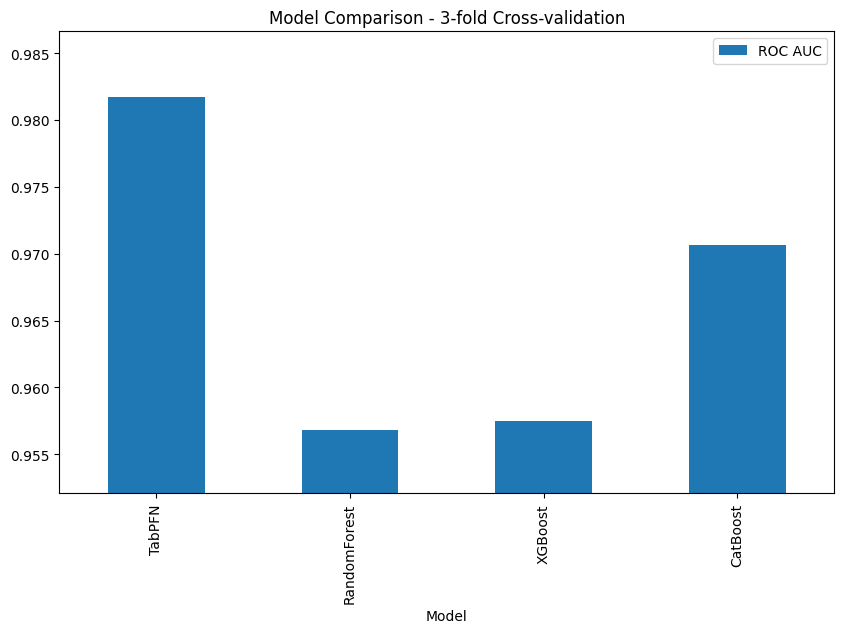

In [7]:
# Compare different machine learning models by training each one multiple times
# on different parts of the data and averaging their performance scores for a
# more reliable performance estimate

# Encode target labels to classes for baselines
le = LabelEncoder()
y = le.fit_transform(y)

# Define models
models = [
    ("TabPFN", TabPFNClassifier(random_state=42)),
    (
        "RandomForest",
        make_pipeline(
            column_transformer,  # string data needs to be encoded for model
            RandomForestClassifier(random_state=42),
        ),
    ),
    (
        "XGBoost",
        make_pipeline(
            column_transformer,  # string data needs to be encoded for model
            XGBClassifier(random_state=42),
        ),
    ),
    (
        "CatBoost",
        make_pipeline(
            column_transformer,  # string data needs to be encoded for model
            CatBoostClassifier(random_state=42, verbose=0),
        ),
    ),
]

# Calculate scores
n_splits = 3
cv = StratifiedKFold(n_splits=n_splits, random_state=42, shuffle=True)
scoring = "roc_auc_ovr" if len(np.unique(y)) > 2 else "roc_auc"
scores = {
    name: cross_val_score(model, X, y, cv=cv, scoring=scoring, n_jobs=1, verbose=1)
    for name, model in models
}

# Plot results
df = pd.DataFrame(
    [(k, v.mean()) for (k, v) in scores.items()], columns=["Model", "ROC AUC"]
)
ax = df.plot(x="Model", y="ROC AUC", kind="bar", figsize=(10, 6))
ax.set_ylim(df["ROC AUC"].min() * 0.995, min(1.0, df["ROC AUC"].max() * 1.005))
ax.set_title(f"Model Comparison - {n_splits}-fold Cross-validation")

### Auto TabPFN Classifier (Best Predictice Performance)
The AutoTabPFN classifier enhances the standard TabPFN by employing a post-hoc ensemble technique, which is similar to stacking. This method combines predictions from multiple models to improve overall predictive performance. In this section, we'll demonstrate how to use the AutoTabPFN classifier and compare its performance against the standard TabPFN and other baseline models.

In [8]:
from tabpfn_extensions import AutoTabPFNClassifier

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42
)

# Train and evaluate the TabPFN classifier
tabpfn_classifier = AutoTabPFNClassifier(
    random_state=42,
    eval_metric="roc_auc",  # which metric are we optimizing?
    max_time=60,  # maximum runtime 60 seconds
)
tabpfn_classifier.fit(X_train, y_train)
y_pred_proba = tabpfn_classifier.predict_proba(X_test)

# Calculate the ROC AUC score
roc_auc = roc_auc_score(y_test, y_pred_proba[:, 1])
print(f"TabPFN ROC AUC Score: {roc_auc:.4f}")

tabpfn-v2-classifier-vutqq28w.ckpt:   0%|          | 0.00/12.9M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/37.0 [00:00<?, ?B/s]

tabpfn-v2-classifier-od3j1g5m.ckpt:   0%|          | 0.00/29.0M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/37.0 [00:00<?, ?B/s]

tabpfn-v2-classifier-llderlii.ckpt:   0%|          | 0.00/29.0M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/37.0 [00:00<?, ?B/s]

tabpfn-v2-classifier-gn2p4bpt.ckpt:   0%|          | 0.00/12.9M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/37.0 [00:00<?, ?B/s]

tabpfn-v2-classifier.ckpt:   0%|          | 0.00/29.0M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/37.0 [00:00<?, ?B/s]

tabpfn-v2-classifier-znskzxi4.ckpt:   0%|          | 0.00/12.9M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/37.0 [00:00<?, ?B/s]

TabPFN ROC AUC Score: 0.9777


# Regression with TabPFN <a name="regression"></a>

Next, we'll explore how to use TabPFN for regression tasks. We will use the Boston Housing dataset, where the goal is to predict the median value of owner-occupied homes.

We will measure performance using the [Root Mean Squared Error](https://scikit-learn.org/1.5/modules/generated/sklearn.metrics.root_mean_squared_error.html), and again, we will compare TabPFN with other popular regression models.

In [9]:
# Load the Boston Housing dataset
df_boston = fetch_openml(data_id=531, as_frame=True)
X, y = df_boston.data, df_boston.target

# Display the dataset description and data
display(Markdown("### Boston Housing Dataset"))
display(Markdown(df_boston["DESCR"]))
display(X.head())

### Boston Housing Dataset

**Author**:   
**Source**: Unknown - Date unknown  
**Please cite**:   

The Boston house-price data of Harrison, D. and Rubinfeld, D.L. 'Hedonic
prices and the demand for clean air', J. Environ. Economics & Management,
vol.5, 81-102, 1978.   Used in Belsley, Kuh & Welsch, 'Regression diagnostics
...', Wiley, 1980.   N.B. Various transformations are used in the table on
pages 244-261 of the latter.
Variables in order:
CRIM     per capita crime rate by town
ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
INDUS    proportion of non-retail business acres per town
CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
NOX      nitric oxides concentration (parts per 10 million)
RM       average number of rooms per dwelling
AGE      proportion of owner-occupied units built prior to 1940
DIS      weighted distances to five Boston employment centres
RAD      index of accessibility to radial highways
TAX      full-value property-tax rate per $10,000
PTRATIO  pupil-teacher ratio by town
B        1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town
LSTAT    % lower status of the population
MEDV     Median value of owner-occupied homes in $1000's


Information about the dataset
CLASSTYPE: numeric
CLASSINDEX: last

Downloaded from openml.org.

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33


In [10]:
# Alternative datasets (commented for reference):

# Liver Disorders dataset
# Classification task: Predict liver disorder presence
# Features: Blood test results, alcohol consumption
# Samples: 345 patients
# Target: Binary liver disorder diagnosis
# df = fetch_openml("liver-disorders", version=1)

# Grid Stability dataset
# Regression task: Predict electrical grid stability
# Features: Power system measurements, grid parameters
# Samples: 10,000 simulations
# Target: Grid stability score
# df = fetch_openml(data_id=44973, as_frame=True)

# Concrete Compressive Strength dataset
# Regression task: Predict concrete strength
# Features: Concrete components (cement, water, aggregates)
# Samples: 1,030 concrete samples
# Target: Compressive strength in MPa
# df = fetch_openml(data_id=44959, as_frame=True)

In [11]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42
)

# Train and evaluate the TabPFN regressor
tabpfn_regressor = TabPFNRegressor(random_state=42)
tabpfn_regressor.fit(X_train, y_train)
y_pred = tabpfn_regressor.predict(X_test)

# Calculate the Root Mean Squared Error
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"TabPFN RMSE: {rmse:.4f}")

tabpfn-v2-regressor.ckpt:   0%|          | 0.00/44.4M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/37.0 [00:00<?, ?B/s]

TabPFN RMSE: 2.5788


### Auto TabPFN Regressor (Best Predictice Performance)
The AutoTabPFN regressor enhances the standard TabPFN by employing a post-hoc ensemble technique, which is similar to stacking. This method combines predictions from multiple models to improve overall predictive performance. In this section, we'll demonstrate how to use the AutoTabPFN regressor and compare its performance against the standard TabPFN and other baseline models.

In [12]:
from tabpfn_extensions import AutoTabPFNRegressor

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42
)

# Train and evaluate the TabPFN regressor
tabpfn_regressor = AutoTabPFNRegressor(
    random_state=42,
    eval_metric="rmse",  # which metric are we optimizing?
    max_time=60,  # maximum runtime 60 seconds
)
tabpfn_regressor.fit(X_train, y_train)
y_pred = tabpfn_regressor.predict(X_test)

# Calculate the Root Mean Squared Error
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"TabPFN RMSE: {rmse:.4f}")

tabpfn-v2-regressor-wyl4o83o.ckpt:   0%|          | 0.00/23.2M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/37.0 [00:00<?, ?B/s]

tabpfn-v2-regressor-09gpqh39.ckpt:   0%|          | 0.00/44.4M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/37.0 [00:00<?, ?B/s]

tabpfn-v2-regressor-2noar4o2.ckpt:   0%|          | 0.00/44.4M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/37.0 [00:00<?, ?B/s]

tabpfn-v2-regressor.ckpt:   0%|          | 0.00/44.4M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/37.0 [00:00<?, ?B/s]

TabPFN RMSE: 2.4910


### Comparing TabPFN with Other Regressors

Now, let's see how TabPFN's regression performance stacks up against other models using cross-validation.


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    2.0s finished
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    6.7s finished


Text(0.5, 1.0, 'Model Comparison - 3-fold Cross-validation \n (Variance Explained - Larger is better)')

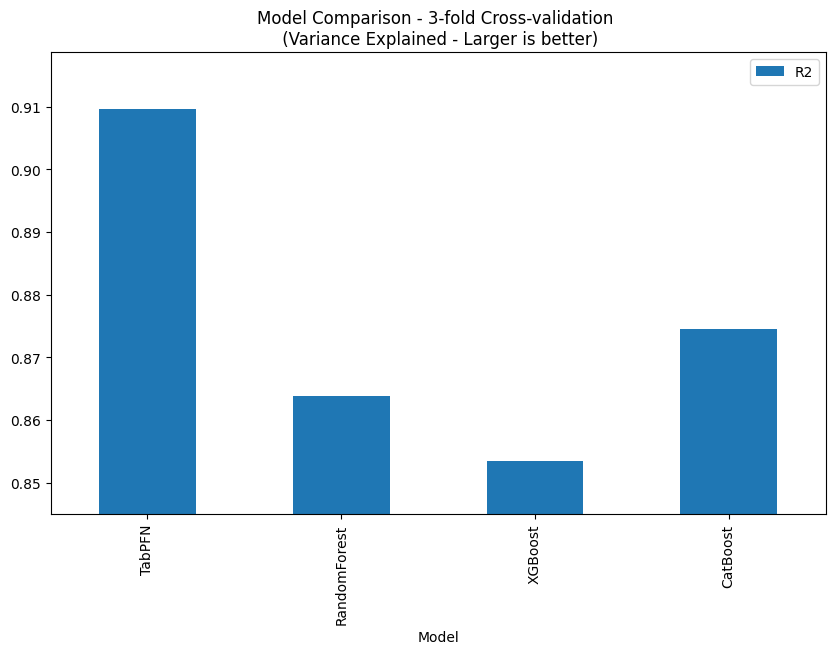

In [13]:
# Compare different machine learning models by training each one multiple times
# on different parts of the data and averaging their performance scores for a
# more reliable performance estimate

# Define models
models = [
    ("TabPFN", TabPFNRegressor(random_state=42)),
    (
        "RandomForest",
        make_pipeline(
            column_transformer,  # string data needs to be encoded for model
            RandomForestRegressor(random_state=42),
        ),
    ),
    (
        "XGBoost",
        make_pipeline(
            column_transformer,  # string data needs to be encoded for model
            XGBRegressor(random_state=42),
        ),
    ),
    (
        "CatBoost",
        make_pipeline(
            column_transformer,  # string data needs to be encoded for model
            CatBoostRegressor(random_state=42, verbose=0),
        ),
    ),
]

# Calculate scores
scoring = "r2"
n_splits = 3
cv = KFold(n_splits=n_splits, random_state=42, shuffle=True)
scores = {
    name: cross_val_score(model, X, y, cv=cv, scoring=scoring, n_jobs=1, verbose=1)
    for name, model in models
}


# Plot results
df = pd.DataFrame([(k, v.mean()) for (k, v) in scores.items()], columns=["Model", "R2"])
ax = df.plot(x="Model", y="R2", kind="bar", figsize=(10, 6))
ax.set_ylim(df["R2"].min() * 0.99, df["R2"].max() * 1.01)
ax.set_title(
    f"Model Comparison - {n_splits}-fold Cross-validation \n (Variance Explained - Larger is better)"
)

# Handling Text Data <a name="text-data"></a>

A powerful feature of the TabPFN server is its ability to handle text data directly, without the need for manual feature engineering. This simplifies the process of working with datasets that contain a mix of numerical and textual features.

**Note:** This feature is only available when using the 'client' backend.

In [14]:
if backend != "client":
    console.print(
        Panel(
            "[bold yellow]Text data can only be processed through the TabPFN server. Please restart the notebook and select the 'client' backend to run this section.[/bold yellow]",
            title="[bold yellow]Warning",
            border_style="yellow",
        )
    )
else:
    # We will use gdown to download the dataset
    !gdown --fuzzy "17bJekFGIAxbrdcBeBIvcyZjneweY581E"

    # Load the clothing review dataset
    # We restrict to 500 rows to make the example faster
    df_text = pd.read_csv("cloth.csv", index_col=0).dropna()[:500]

    # Define features and target
    y_text = df_text["Rating"]
    X_text = df_text.drop(columns=["Rating"])

    print("Text dataset loaded successfully!")
    display(X_text.head())

╭──────────────────────────────────────────────────── Warning ────────────────────────────────────────────────────╮
│ Text data can only be processed through the TabPFN server. Please restart the notebook and select the 'client'  │
│ backend to run this section.                                                                                    │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

### Comparing Text Handling

Now, let's compare how TabPFN handles text natively versus how a baseline model like RandomForest needs a specific text processing pipeline.

For baselines, we will create a pipeline that converts strings to ordinal features.

For TabPFN, we simply pass the raw data with the text column directly to the classifier.

In [15]:
if backend == "client":
    # Encode target labels to classes for baselines
    le = LabelEncoder()
    y_text = le.fit_transform(y_text)

    # Define models
    models = [
        ("TabPFN-Text", TabPFNClassifier(random_state=42)),
        (
            "TabPFN",
            make_pipeline(
                column_transformer,  # string data needs to be encoded for model
                TabPFNClassifier(random_state=42),
            ),
        ),
        (
            "RandomForest",
            make_pipeline(
                column_transformer,  # string data needs to be encoded for model
                RandomForestClassifier(random_state=42),
            ),
        ),
        (
            "XGBoost",
            make_pipeline(
                column_transformer,  # string data needs to be encoded for model
                XGBClassifier(random_state=42),
            ),
        ),
        (
            "CatBoost",
            make_pipeline(
                column_transformer,  # string data needs to be encoded for model
                CatBoostClassifier(random_state=42, verbose=0),
            ),
        ),
    ]

    # Calculate scores
    cv = StratifiedKFold(n_splits=3, random_state=42, shuffle=True)
    scoring = "roc_auc_ovr" if len(np.unique(y_text)) > 2 else "roc_auc"
    scores = {
        name: cross_val_score(
            model, X_text, y_text, cv=cv, scoring=scoring, n_jobs=1, verbose=1
        ).mean()
        for name, model in models
    }

    # Plot results
    df = pd.DataFrame(list(scores.items()), columns=["Model", "ROC AUC"])
    ax = df.plot(x="Model", y="ROC AUC", kind="bar", figsize=(10, 6))
    ax.set_ylim(df["ROC AUC"].min() * 0.995, min(1.0, df["ROC AUC"].max() * 1.005))
    ax.set_title("Model Comparison - 5-fold Cross-validation")

# Unsupervised Learning with TabPFN <a name="unsupervised-learning"></a>

TabPFN can also be used for unsupervised learning tasks like outlier detection and synthetic data generation. These features are available through the `tabpfn-extensions` library.


### Data Generation

100%|██████████| 3/3 [00:05<00:00,  1.85s/it]


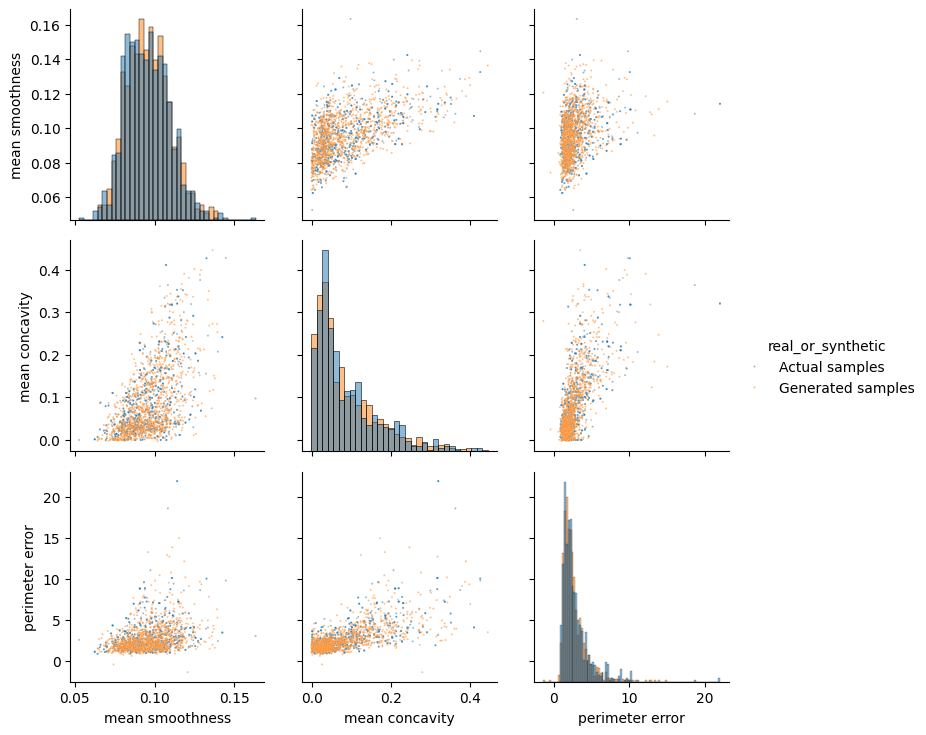

In [16]:
from tabpfn_extensions import unsupervised

# Load and prepare breast cancer dataset
df = load_breast_cancer(return_X_y=False)
X, y = df["data"], df["target"]
feature_names = df["feature_names"]

# Initialize TabPFN models
model_unsupervised = unsupervised.TabPFNUnsupervisedModel(
    tabpfn_clf=TabPFNClassifier(), tabpfn_reg=TabPFNRegressor()
)

# Select features for synthetic data generation
# Example features: [mean texture, mean area, mean concavity]
feature_indices = [4, 6, 12]

# Run synthetic data generation experiment
experiment = unsupervised.experiments.GenerateSyntheticDataExperiment(
    task_type="unsupervised"
)

results = experiment.run(
    tabpfn=model_unsupervised,
    X=torch.tensor(X),
    y=torch.tensor(y),
    attribute_names=feature_names,
    temp=1.0,  # Temperature parameter for sampling
    n_samples=X.shape[0] * 2,  # Generate twice as many samples as original data
    indices=feature_indices,
)

### Outlier detection

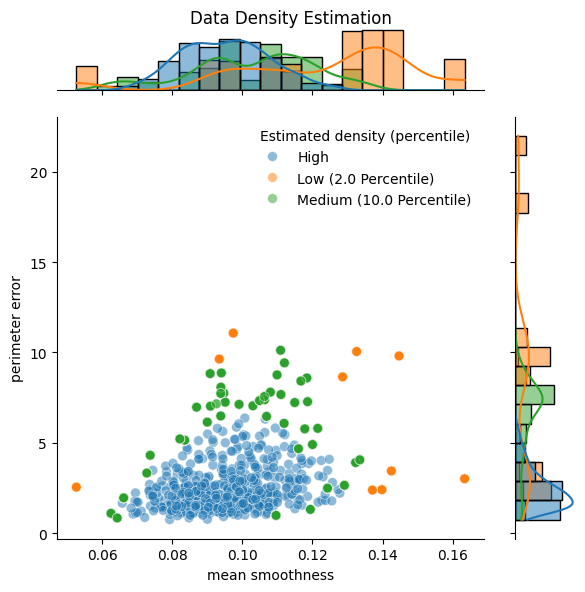

In [17]:
import torch
from sklearn.datasets import load_breast_cancer
from tabpfn_extensions import unsupervised

# Load data
df = load_breast_cancer(return_X_y=False)
X, y = df["data"], df["target"]
attribute_names = df["feature_names"]

# Initialize models
clf = TabPFNClassifier(n_estimators=4)
reg = TabPFNRegressor(n_estimators=4)
model_unsupervised = unsupervised.TabPFNUnsupervisedModel(
    tabpfn_clf=clf, tabpfn_reg=reg
)

# Run outlier detection
exp_outlier = unsupervised.experiments.OutlierDetectionUnsupervisedExperiment(
    task_type="unsupervised"
)
results = exp_outlier.run(
    tabpfn=model_unsupervised,
    X=torch.tensor(X, dtype=torch.float32),
    y=torch.tensor(y),
    attribute_names=attribute_names,
    indices=[4, 12],  # Analyze features 4 and 12
)

### Missing value imputation

In [18]:
# --- 1. Load and Prepare Data ---
# Load the breast cancer dataset
df = load_breast_cancer(return_X_y=False)
X, y = df["data"], df["target"]

# Split the data into training and testing sets
X_train, X_test = train_test_split(
    X,
    test_size=0.33,
    random_state=42,
)

# --- 2. Introduce Missing Values ---
# Create a copy of the test set to introduce missing values (NaNs)
X_test_missing = X_test.copy()
n_samples, n_features = X_test_missing.shape

# Introduce missing values in the first three columns for demonstration
missing_fraction = 0.3
n_missing = int(n_samples * missing_fraction)

for col_idx in range(3):
    # Choose random rows to set to NaN
    missing_indices = np.random.choice(n_samples, n_missing, replace=False)
    X_test_missing[missing_indices, col_idx] = np.nan

print(f"Introduced {np.isnan(X_test_missing).sum()} missing values into the test set.")
print(pd.DataFrame(X_test_missing[:, 0:3]).head())

# --- 3. Initialize the Unsupervised Model ---
# Initialize TabPFN models for regression and classification tasks.
# The unsupervised model uses these to model the data distribution.
clf = TabPFNClassifier(n_estimators=3)
reg = TabPFNRegressor(n_estimators=3)

# Initialize the main unsupervised model
model_unsupervised = unsupervised.TabPFNUnsupervisedModel(
    tabpfn_clf=clf,
    tabpfn_reg=reg,
)

# --- 4. Fit and Impute ---
# Fit the model on the complete training data (without missing values)
print("Fitting the unsupervised model on the training data...")
model_unsupervised.fit(X_train)

# Perform imputation on the test set
print("Imputing missing values...\n")
X_imputed_tensor = model_unsupervised.impute(
    X_test_missing,
    n_permutations=5,  # Fewer permutations for a quicker example
)

print("\n------------------------")

# --- 5. Verify Results ---
# Check that the imputed data no longer contains any NaN values
n_missing_after = torch.isnan(X_imputed_tensor).sum().item()

print(f"\nNumber of missing values after imputation: {n_missing_after}")
print(pd.DataFrame(X_imputed_tensor[:, 0:3]).head())

# Optional: Calculate the Mean Squared Error for the imputed values,
# since we know the original ground truth values.
original_nan_mask = np.isnan(X_test_missing)
imputed_values = X_imputed_tensor.numpy()[original_nan_mask]
original_values = X_test[original_nan_mask]

mse = np.mean((imputed_values - original_values) ** 2)
print(f"Mean Squared Error of imputed values vs. original values: {mse:.4f}")

Introduced 168 missing values into the test set.
       0      1       2
0  12.47  18.60     NaN
1  18.94  21.31  123.60
2  15.46  19.48     NaN
3    NaN  17.68   81.47
4  11.54    NaN   74.65
Fitting the unsupervised model on the training data...
Imputing missing values...



100%|██████████| 3/3 [00:13<00:00,  4.44s/it]


------------------------

Number of missing values after imputation: 0
           0          1           2
0  12.470000  18.600000   81.107605
1  18.940001  21.309999  123.599998
2  15.460000  19.480000  101.601982
3  12.451792  17.680000   81.470001
4  11.540000  14.962588   74.650002
Mean Squared Error of imputed values vs. original values: 1.7337


# Model Interpretability <a name="interpretability"></a>

Understanding *why* a model makes certain predictions is crucial for building trust and for debugging. The `tabpfn-extensions` library provides tools for model interpretability. We'll look at SHAP (SHapley Additive exPlanations) values, which show the impact of each feature on a specific prediction.

### Shapley Values

Next, we'll use SHAP to understand our model's predictions. SHAP values break down a prediction to show the contribution of each feature, helping us see which factors are most influential for a given data point.


PermutationExplainer explainer: 51it [02:46,  3.39s/it]


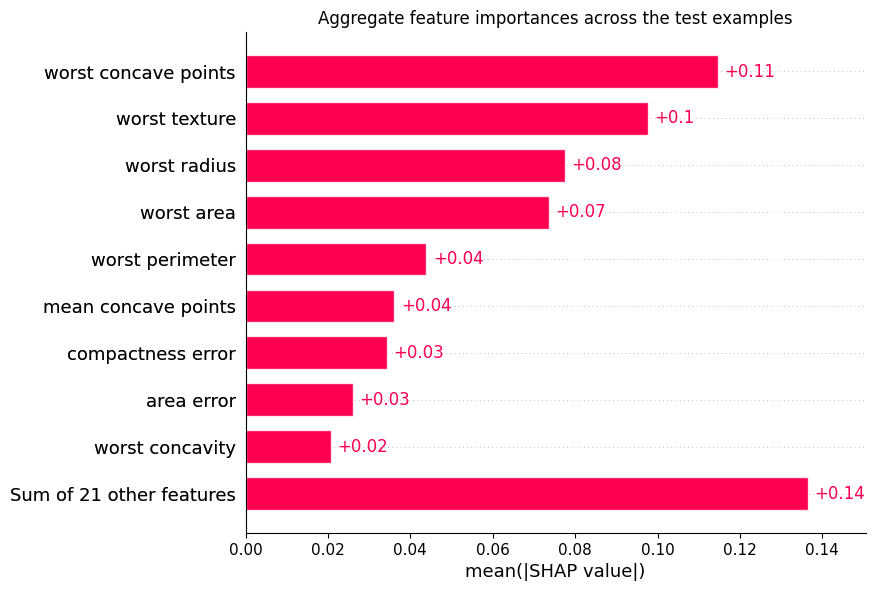

/content/tabpfn-extensions/src/tabpfn_extensions/interpretability/shap.py:134: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values=shap_values, show=False)


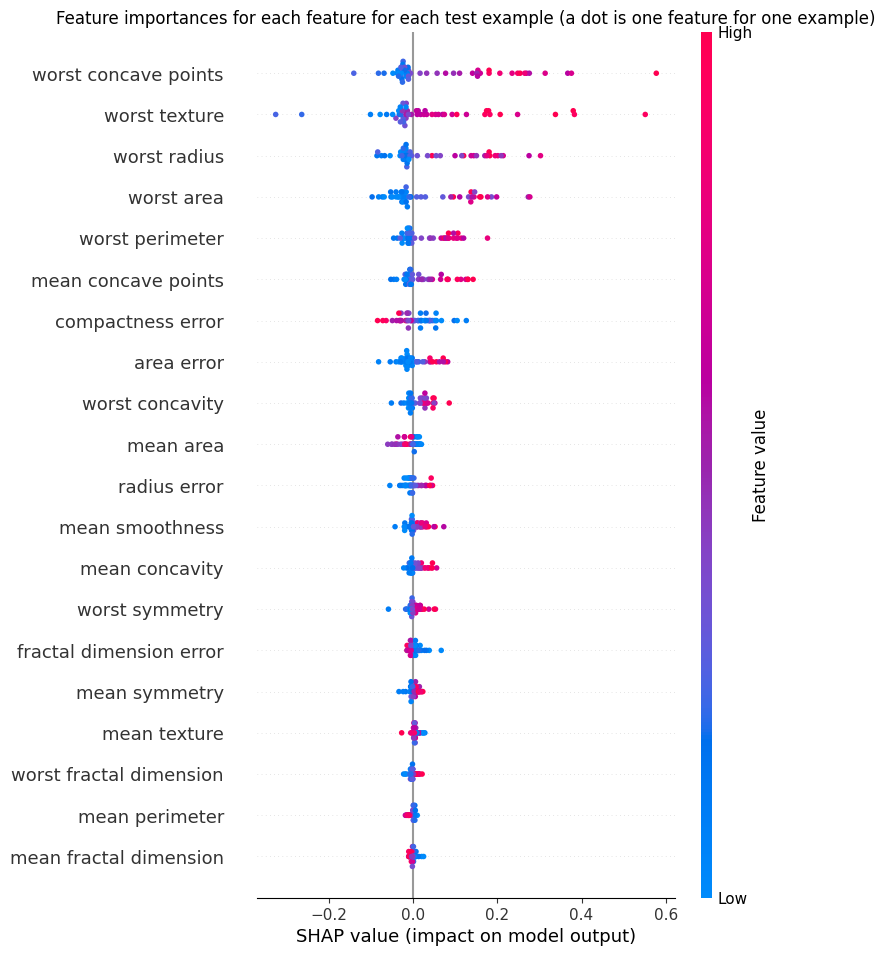

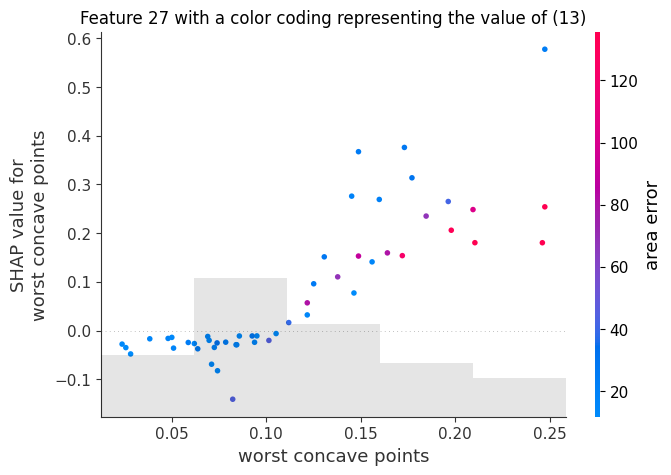

In [19]:
from tabpfn_extensions import interpretability

# Load example dataset
data = load_breast_cancer()
X, y = data.data, data.target
feature_names = data.feature_names
n_samples = 50

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)

# Initialize and train model
clf = TabPFNClassifier()
clf.fit(X_train, y_train)

# Calculate SHAP values
shap_values = interpretability.shap.get_shap_values(
    estimator=clf,
    test_x=X_test[:n_samples],
    attribute_names=feature_names,
    algorithm="permutation",
)

# Create visualization
fig = interpretability.shap.plot_shap(shap_values)

### Embeddings

This example demonstrates how to extract embeddings from TabPFN models and use them
for classification and regression tasks.

NOTE: This example requires the full TabPFN implementation (pip install tabpfn).
It will not work with the TabPFN client (pip install tabpfn-client) because
the embedding functionality is not available in the client version.


Loading classification dataset (breast cancer)...
Baseline Logistic Regression Accuracy: 0.9614
Logistic Regression with TabPFN (Vanilla) Accuracy: 0.9825

Applying t-SNE for visualization on the TEST SET only...


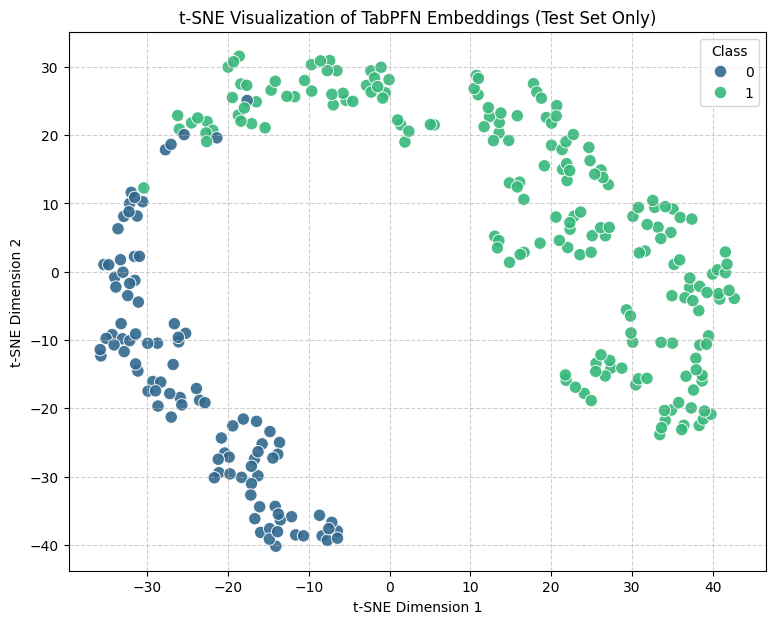

In [20]:
if backend == "client":
    console.print(
        Panel(
            "[bold yellow]Text data can only be processed through the TabPFN server. Please restart the notebook and select the 'client' backend to run this section.[/bold yellow]",
            title="[bold yellow]Warning",
            border_style="yellow",
        )
    )
else:
    import matplotlib.pyplot as plt
    import numpy as np
    import pandas as pd
    import seaborn as sns
    from sklearn.datasets import load_breast_cancer, load_diabetes
    from sklearn.linear_model import LinearRegression, LogisticRegression
    from sklearn.manifold import TSNE
    from sklearn.metrics import accuracy_score, r2_score
    from sklearn.model_selection import train_test_split
    from tabpfn_extensions import TabPFNClassifier, TabPFNRegressor
    from tabpfn_extensions.embedding import TabPFNEmbedding

    # Load and evaluate classification dataset
    print("Loading classification dataset (breast cancer)...")
    df = load_breast_cancer(return_X_y=False)
    X, y = df["data"], df["target"]
    attribute_names = df["feature_names"]

    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(
        X,
        y,
        test_size=0.5,
        random_state=42,
    )

    # Train and evaluate vanilla logistic regression
    model = LogisticRegression(
        max_iter=10000,
        random_state=42,
    )
    model.fit(X_train, y_train)
    print(
        f"Baseline Logistic Regression Accuracy: {accuracy_score(y_test, model.predict(X_test)):.4f}",
    )

    # Train and evaluate TabPFN embeddings (vanilla)
    clf = TabPFNClassifier(n_estimators=1, random_state=42)
    embedding_extractor = TabPFNEmbedding(tabpfn_clf=clf, n_fold=0)
    train_embeddings = embedding_extractor.get_embeddings(
        X_train,
        y_train,
        X_test,
        data_source="train",
    )
    test_embeddings = embedding_extractor.get_embeddings(
        X_train,
        y_train,
        X_test,
        data_source="test",
    )

    model = LogisticRegression(
        max_iter=10000,
        random_state=42,
    )
    model.fit(train_embeddings[0], y_train)
    y_pred = model.predict(test_embeddings[0])
    print(
        f"Logistic Regression with TabPFN (Vanilla) Accuracy: {accuracy_score(y_test, y_pred):.4f}",
    )

    # Note: Using test_embeddings and y_test from your original script.
    # The embeddings have shape (n_splits, n_samples, n_features), so we use the first split [0].
    test_only_embeddings = test_embeddings[0]

    # Apply t-SNE to reduce the TEST embeddings to 2 dimensions.
    # The number of samples in the test set is len(y_test). Perplexity must be less than that.
    # We'll set perplexity to 30, which is suitable for this dataset size.
    print("\nApplying t-SNE for visualization on the TEST SET only...")
    tsne = TSNE(n_components=2, random_state=42, perplexity=10)
    embeddings_2d = tsne.fit_transform(test_only_embeddings)

    # Create a DataFrame for easy plotting
    df_plot = pd.DataFrame(
        {
            "t-SNE-1": embeddings_2d[:, 0],
            "t-SNE-2": embeddings_2d[:, 1],
            "label": y_test,
        }
    )

    # Plot the 2D embeddings for the test set
    plt.figure(figsize=(9, 7))
    sns.scatterplot(
        data=df_plot,
        x="t-SNE-1",
        y="t-SNE-2",
        hue="label",  # Color points by their class label
        palette="viridis",
        alpha=0.9,
        s=80,
    )

    plt.title("t-SNE Visualization of TabPFN Embeddings (Test Set Only)")
    plt.xlabel("t-SNE Dimension 1")
    plt.ylabel("t-SNE Dimension 2")
    plt.legend(title="Class")
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.show()

### Feature selection

Feature selection is the process of selecting a subset of relevant features for use in model construction. It's useful for reducing model complexity, improving performance by removing noise, and decreasing training time. Here, we'll use Sequential Forward Selection (SFS), which starts with no features and iteratively adds the feature that most improves the model's performance.

The goal is to see if we can create a simpler, faster model with fewer features without a significant drop in accuracy.


In [ ]:
from tabpfn_extensions import interpretability

# Load data
data = load_breast_cancer()
X, y = data.data, data.target
feature_names = data.feature_names

# Initialize model
clf = TabPFNClassifier(n_estimators=1)

# Feature selection
sfs = interpretability.feature_selection.feature_selection(
    estimator=clf, X=X, y=y, n_features_to_select=4, feature_names=feature_names
)

# Print selected features
selected_features = [
    feature_names[i] for i in range(len(feature_names)) if sfs.get_support()[i]
]
print("\nSelected features:")
for feature in selected_features:
    print(f"- {feature}")

# Predictive Behavior of TabPFN <a name="behavior"></a>

In this section, we explore the behavior of predictions from TabPFN on various toy functions.

## Decision Boundary during Classification

First, let us inspect the decision boundary for different classifiers.
The decision bounds show how smoothly a model learns to transition between classes and how well it fits the data.

In the first cell, we create the data and code to plot the decision boundary. The second cell then generates the plot.

In [ ]:
from matplotlib.colors import ListedColormap
from sklearn.inspection import DecisionBoundaryDisplay


# Toy functions that generate the data
def generate_circle(n_datapoints, radius, noise_factor):
    angles = np.linspace(0, 2 * np.pi, n_datapoints).T
    x = radius * np.cos(angles) + np.random.randn(n_datapoints) * noise_factor
    y = radius * np.sin(angles) + np.random.randn(n_datapoints) * noise_factor

    return np.stack([x, y]).T


def generate_concentric_cirlces(radii, num_points_per_circle, noise_factor=1 / 15):
    circles = []
    for r, num_points in zip(radii, num_points_per_circle):
        circles.append(generate_circle(num_points, r, noise_factor))

    return np.vstack(circles)


def generate_circle_data(num_points_per_circle, radii, noise_factor):
    radii = np.array(radii)
    circles_1 = generate_concentric_cirlces(radii, num_points_per_circle, noise_factor)
    circles_1 = np.hstack([circles_1, np.zeros((sum(num_points_per_circle), 1))])

    circles_2 = generate_concentric_cirlces(
        radii + 0.3, num_points_per_circle, noise_factor
    )
    circles_2 = np.hstack([circles_2, np.ones((sum(num_points_per_circle), 1))])

    circles = np.vstack([circles_1, circles_2])
    X, y = circles[:, :2], circles[:, 2]
    return X, y


# Generate the data
X_train, y_train = generate_circle_data(
    num_points_per_circle=[50, 100, 200], radii=[1, 2, 4], noise_factor=0.1
)


# Function for plotting
def plot_decision_boundary(ax, model, model_name):
    cmap = ListedColormap(["#FF0000", "#0000FF"])
    ax.set_title(model_name)
    DecisionBoundaryDisplay.from_estimator(
        model,
        X_train[:, :2],
        alpha=0.6,
        ax=ax,
        eps=0.2,
        grid_resolution=50,
        response_method="predict_proba",
        cmap=plt.cm.RdBu,
    )
    ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train > 0, cmap=cmap)

In [ ]:
rf = RandomForestClassifier().fit(X_train[:, :2], y_train)
xgb = XGBClassifier().fit(X_train[:, :2], y_train)
tabpfn = TabPFNClassifier().fit(X_train[:, :2], y_train)

# Create a 2x2 subplot layout
fig, axes = plt.subplots(2, 2, figsize=(7, 7))

# Plot Train Points
ax_points = axes[0, 0]
ax_points.set_title("Train points")
ax_points.scatter(
    X_train[:, 0], X_train[:, 1], c=y_train, cmap=ListedColormap(["#FF0000", "#0000FF"])
)

# Plot Random Forest
ax_rf = axes[0, 1]
plot_decision_boundary(ax_rf, rf, "Random Forest")

# Plot XGBoost
ax_xgb = axes[1, 0]
plot_decision_boundary(ax_xgb, xgb, "XGBoost")

# Plot TabPFN
ax_tabpfn = axes[1, 1]
plot_decision_boundary(ax_tabpfn, tabpfn, "TabPFN")

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

## Sin Curve Fitting with Regression

Next, we investigate the curve-fitting behavior of the different models on a sin curve.

In [ ]:
# Toy function to generate data
def generate_sinx_plus_x(N):
    x = np.linspace(0, 20, N)
    y = np.sin(x) + x / 10

    return x.reshape(-1, 1), y


# Utility function for plotting
def plot_predictions(ax, model, model_name):
    X_test = np.linspace(0, 20, 200).reshape(
        -1, 1
    )  # Predict for 200 points  between 0 and 20
    y_preds = model.predict(X_test)
    ax.set_title(model_name)
    ax.scatter(X_test, y_preds, label="Predictions")
    ax.scatter(X_train, y_train, label="Train points")
    ax.legend()


# Generate data
X_train, y_train = generate_sinx_plus_x(N=40)

# Fit Models
rf = RandomForestRegressor(random_state=42).fit(X_train, y_train)
xgb = XGBRegressor(random_state=42).fit(X_train, y_train)
tabpfn = TabPFNRegressor()
tabpfn.fit(X_train, y_train)

# Create a 2x2 subplot layout
fig, axs = plt.subplots(2, 2, figsize=(14, 12))

# Plot train points
ax_points = axs[0, 0]
ax_points.set_title("Train points")
ax_points.scatter(X_train, y_train, label="Train points")
ax_points.legend()

# Plot predictions for Random Forest
ax_rf = axs[0, 1]
plot_predictions(ax_rf, rf, "Random Forest")

# Plot predictions for XGBoost
ax_xgb = axs[1, 0]
plot_predictions(ax_xgb, xgb, "XGBoost")

# Plot predictions for TabPFN
ax_tabpfn = axs[1, 1]
plot_predictions(ax_tabpfn, tabpfn, "TabPFN")

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

## Uncertainty of TabPFN / Quantile Regresison

---



TabPFN is trained to predict the distribution of the target variable and not just a single point. This is also the case for regression.

As a result, we natively obtain uncertainty for the predictions of TabPFN (without the need for a new model or repeating models for different quantiles).

In the following, we plot the uncertainty of TabPFN for a toy function with noise.

In [ ]:
### Code to generate the plot (feel free to ignore)
def plot_regression_uncertainty(ax, x, y_line, y_noisy, x_test, color_multiplier=5):
    all_quantiles = preds["quantiles"]
    y = np.array(all_quantiles)  # shape of y: (9, number of samples)

    # Calculate the maximum and minimum values in y
    y_max = np.max(y, axis=0)
    y_min = np.min(y, axis=0)

    # Calculate the widths of each quantile bin
    quantile_bin_widths = np.diff(
        y, axis=0
    )  # shape of quantile_bin_widths: (8, number of samples)

    # Normalize the bin widths for a given x
    per_x_normalized_bin_widths = (quantile_bin_widths) / (y_max - y_min)

    # Plotting
    num_bins, num_data_points = (
        per_x_normalized_bin_widths.shape[0],
        per_x_normalized_bin_widths.shape[1],
    )
    rect_width = (
        x_test[1] - x_test[0]
    ).squeeze()  # assuming the x query points are equally spaced out

    for i in range(num_data_points):
        for j in range(num_bins):
            quantile_bin_widths[j, i]
            rect = plt.Rectangle(
                xy=(x_test[i][0] - rect_width / 2, y[j, i]),
                width=rect_width,
                height=quantile_bin_widths[j, i],
                facecolor=plt.cm.viridis(
                    per_x_normalized_bin_widths[j, i] * color_multiplier
                ),
                edgecolor="none",
            )
            ax.add_patch(rect)

    # Set limits and labels
    ax.plot(x, y_line, label="True line", color="blue")
    ax.set_xlim(min(x_test) - 1, max(x_test) + 1)
    ax.set_ylim(np.min(y_noisy) - 1, np.max(y_noisy) + 1)
    ax.set_xlabel("X")
    ax.set_ylabel("Y")

    # ax.plot(x, y, label='True line', color='blue')
    ax.scatter(x, y_noisy, label="Noisy data", color="red", s=10)

    plt.title("TabPFN Regression Uncertainty")
    plt.show()


# Generate Data
def generate_line_with_heteroscedastic_noise(
    m=0.8, num_points=200, x_start=0, x_end=100, noise_factor=0.1
):
    x = np.linspace(x_start, x_end, num_points)
    noise = np.random.randn(num_points)
    y = m * x
    y_noisy = y + (noise * noise_factor * x)

    return x.reshape(-1, 1), y, y_noisy


def generate_line_with_heteroscedastic_noise_with_gap(
    m=0.8, num_points=200, x_start=0, x_end=100, noise_factor=0.1
):
    extra_points = num_points // 3
    x, y, y_noisy = generate_line_with_heteroscedastic_noise(
        m, num_points + extra_points, x_start, x_end, noise_factor
    )
    a = np.arange(num_points + extra_points)
    idx = np.where((a < num_points / 3) | (a > num_points / 3 + extra_points))
    return x[idx], y[idx], y_noisy[idx]


x, y_line, y_noisy = generate_line_with_heteroscedastic_noise_with_gap(0.8)
x_test = np.linspace(0, 100, 200).reshape(-1, 1)

In [ ]:
reg = TabPFNRegressor()
reg.fit(x, y_noisy)
preds = reg.predict(x_test, output_type="full")

In [ ]:
fig = plt.figure(figsize=(12, 6))

# Plot the original data
ax = fig.add_subplot(121)
ax.plot(x, y_line, label="True line", color="blue")
ax.scatter(x, y_noisy, label="Noisy data", color="red", s=10)
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_xlim(min(x) - 1, max(x) + 1)
ax.set_ylim(np.min(y_noisy) - 1, np.max(y_noisy) + 1)
ax.set_title("Heteroscedastic Noise along a Sloping Line")
ax.legend()

# plot the uncertainty estimates obtained from TabPFN
ax = fig.add_subplot(122)
plot_regression_uncertainty(ax, x, y_line, y_noisy, x_test, color_multiplier=5)

# Time Series Forecasting <a name="timeseries"></a>

TabPFN can be used for time series prediction, following the work of Hoo et al. (Zero-Shot Time Series Forecasting with TabPFNv2; https://arxiv.org/abs/2501.02945v3).

In this demo, we will use the time series dataset from [Chronos Dataset](https://huggingface.co/datasets/autogluon/chronos_datasets) on HuggingFace. Also, we'll keep it short and work with just 2 time series from the dataset.

Feel free to explore other datasets by using the dataset names from Chronos Dataset on HuggingFace or even use time series data of your own problem.


## *Installation*

In [ ]:
!uv pip install tabpfn-time-series
raise ValueError(
    "Make sure to restart the session before proceeding, otherwise errors will follow (Runtime > Restart Session)"
)

## Load Time Series Data

In this demo, we will use the time series dataset from [Chronos Dataset](https://huggingface.co/datasets/autogluon/chronos_datasets) on HuggingFace. Also, we'll keep it short and work with just 2 time series from the dataset.

Feel free to explore other datasets by using the dataset names from Chronos Dataset on HuggingFace or even use time series data of your own problem.

In [ ]:
dataset_metadata = {
    "monash_tourism_monthly": {"prediction_length": 24},
    "m4_hourly": {"prediction_length": 48},
}

dataset_choice = "monash_tourism_monthly"
num_time_series_subset = 2

In [ ]:
from datasets import load_dataset
from tabpfn_time_series import TimeSeriesDataFrame
from tabpfn_time_series.data_preparation import generate_test_X, to_gluonts_univariate

prediction_length = dataset_metadata[dataset_choice]["prediction_length"]
dataset = load_dataset("autogluon/chronos_datasets", dataset_choice)

tsdf = TimeSeriesDataFrame(to_gluonts_univariate(dataset["train"]))
tsdf = tsdf[
    tsdf.index.get_level_values("item_id").isin(tsdf.item_ids[:num_time_series_subset])
]
train_tsdf, test_tsdf_ground_truth = tsdf.train_test_split(
    prediction_length=prediction_length
)
test_tsdf = generate_test_X(train_tsdf, prediction_length)

Let's take a look at the time series data.

In [ ]:
from tabpfn_time_series.plot import plot_actual_ts

plot_actual_ts(train_tsdf, test_tsdf_ground_truth)

## Adding Features

In our paper, we propose adding `Running Index`, `Calendar Features`, and `Auto Seasonal Features` to the table.

**Feel free to experiment with your own features!**

To do that, simply define your own feature functions and pass them to the `FeatureTransformer`.

In [ ]:
from tabpfn_time_series import FeatureTransformer
from tabpfn_time_series.features import (
    AutoSeasonalFeature,
    CalendarFeature,
    RunningIndexFeature,
)

selected_features = [
    RunningIndexFeature(),
    CalendarFeature(),
    AutoSeasonalFeature(),
]

feature_transformer = FeatureTransformer(selected_features)

train_tsdf, test_tsdf = feature_transformer.transform(train_tsdf, test_tsdf)

Let's take a look at the tables (train and test) before we proceed to do predictions.

✅ Realize that we have added some features into the tables.

In [ ]:
train_tsdf.head()

In [ ]:
test_tsdf.head()

## Prediction

Now, let's perform prediction.

We provide two options, `TabPFNMode.LOCAL` and `TabPFNMode.CLIENT`, as the backend for TabPFN.

- `TabPFNMode.LOCAL` uses your local machine to run TabPFN.
- `TabPFNMode.CLIENT` uses TabPFN's inference service provided by [tabpfn-client](https://github.com/automl/tabpfn-client)

For this demo, we'll use `TabPFNMode.CLIENT` to perform prediction. If you have not use the client before, you'll be prompted to create an account.

Note: if your machine doesn't have a GPU, using `TabPFNMode.CLIENT` is recommended -- must faster 😉.


In [ ]:
from tabpfn_time_series import TabPFNMode, TabPFNTimeSeriesPredictor

predictor = TabPFNTimeSeriesPredictor(
    tabpfn_mode=TabPFNMode.LOCAL,  # adapt this to TabPFNMode.CLIENT if using API
)

pred = predictor.predict(train_tsdf, test_tsdf)

## Visualize the Results

Let's visualize the forecasting results.

Also, note that we provide both **point prediction** and **quantile prediction**, how amazing! 😄

In [ ]:
from tabpfn_time_series.plot import plot_pred_and_actual_ts

plot_pred_and_actual_ts(
    train=train_tsdf,
    test=test_tsdf_ground_truth,
    pred=pred,
)

In [ ]:
pred.head()

# Feedback

Let us know what you think!

Write us at Discord: https://discord.gg/qK7AaXPN or just simply create an issue on [GitHub](https://github.com/PriorLabs/tabpfn).

Thank you for trying out our method! 🎉
